In [239]:
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [252]:
data_path = sys.path[0] + "/../data/"
transaction_df = pd.read_csv(data_path + "transaction_data.csv")
transaction_df.sample(5)

,txn_time,txn_date,order_id,uid,shop_id,shop_owner_uid,gmv,rebate
1507,10/31/2019 15:28,10/31/2019,142294404,100245649,473,100559030,80000,20000
1856,10/31/2019 22:06,10/31/2019,142377944,100702363,8862,103768946,70000,20000
658,10/30/2019 19:39,10/30/2019,142107420,101541612,7495,1381677,70000,20000
3759,11/2/2019 9:28,11/2/2019,142690859,101122487,431,1378509,80000,20000
2452,11/1/2019 16:02,11/1/2019,142550713,103002018,3230,103178855,70000,20000


In [241]:
## Remove inapporiate transaction
lst_index_to_exclude = transaction_df[(transaction_df["rebate"] == 0) & (transaction_df["gmv"] > 3)].index
transaction_df = transaction_df[~transaction_df.index.isin(lst_index_to_exclude)]
transaction_df.sample(5)

,txn_time,txn_date,order_id,uid,shop_id,shop_owner_uid,gmv,rebate
882,10/30/2019 14:10,10/30/2019,142019226,103630139,9593,100133715,240000,20000
3224,11/2/2019 9:00,11/2/2019,142686046,102696939,10979,102817559,70000,20000
2098,11/1/2019 8:26,11/1/2019,142424127,1682606,10740,103970526,30000,9000
1776,10/31/2019 13:27,10/31/2019,142254018,100336272,8101,103712834,135000,20000
1787,10/31/2019 21:46,10/31/2019,142375172,100398209,8242,103730574,134000,20000


In [242]:
transaction_df["txn_date"].nunique()

4

In [243]:
gmv_df = transaction_df.groupby("gmv", as_index = False).agg({"order_id": "count", "rebate": "count"})
gmv_df = gmv_df.rename(columns = {"order_id": "total_transactions"})
gmv_df.sample(5)

,gmv,total_transactions,rebate
382,355000,1,1
312,248000,2,2
60,51000,5,5
311,247000,2,2
376,347000,1,1


In [244]:
gmv_with_most_transactions = gmv_df[gmv_df["total_transactions"] == gmv_df["total_transactions"].max()]["gmv"].values[0]
gmv_with_most_transactions

70000

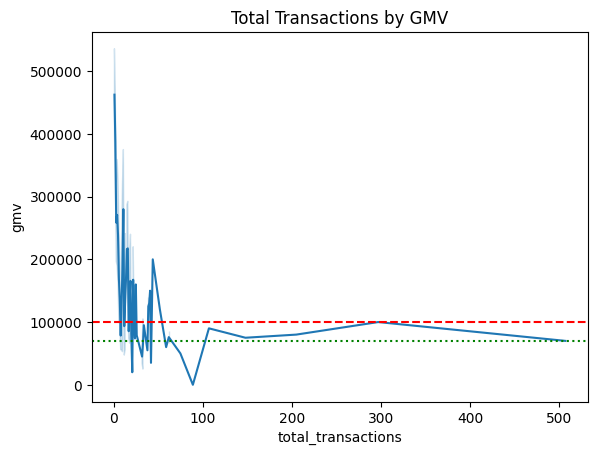

In [253]:
sns.lineplot(data = gmv_df, x = "total_transactions", y = "gmv")
plt.axhline(100000, color = "red", linestyle = "--")
plt.axhline(gmv_with_most_transactions, color = "green", linestyle = ":")
plt.title("Total Transactions by GMV")
plt.show()

In [246]:
gmv_transaction = {
    "GMV Range": ["GMV in (0-70.000)", "GMV in [70.000-100.000]", "GMV over 100.000"],
    "Total Transactions": [gmv_df[(gmv_df["gmv"] > 0) & (gmv_df["gmv"] < 70000)]["total_transactions"].sum(), gmv_df[(gmv_df["gmv"] >= 7000) & (gmv_df["gmv"] <= 100000)]["total_transactions"].sum(),
                           gmv_df[gmv_df["gmv"] > 100000]["total_transactions"].sum()]
}
gmv_range_transaction_df  = pd.DataFrame(gmv_transaction)
gmv_range_transaction_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   GMV Range           3 non-null      object
 1   Total Transactions  3 non-null      int64 
dtypes: int64(1), object(1)
memory usage: 176.0+ bytes


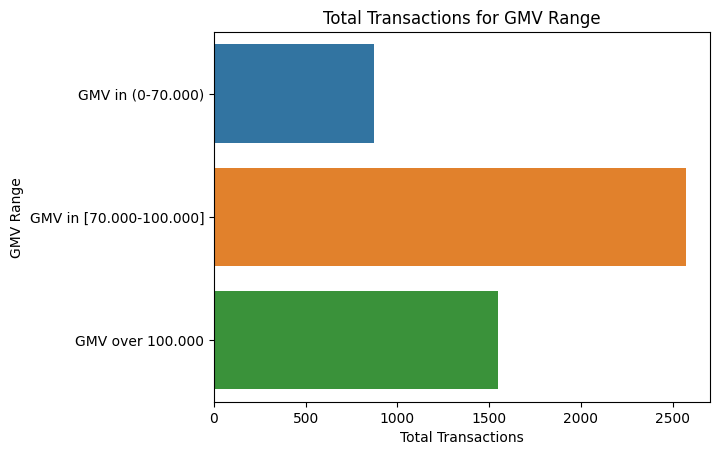

In [247]:
sns.barplot(x = gmv_range_transaction_df["Total Transactions"], y = gmv_range_transaction_df["GMV Range"])
plt.title("Total Transactions for GMV Range")
plt.show()

In [248]:
## Check in 1 day
fraud_detect_df = transaction_df.groupby(["shop_owner_uid", "uid", "txn_date"], as_index = False).agg({"order_id": "count", "rebate": "sum"}).sort_values(by = "order_id", ascending = False)
fraud_detect_df = fraud_detect_df.rename(columns = {"order_id": "total_transactions", "rebate": "total_rebate"})
fraud_detect_df.sample(5)

,shop_owner_uid,uid,txn_date,total_transactions,total_rebate
1033,100305004,1336501,11/1/2019,1,20000
678,1874810,100472516,11/2/2019,1,20000
1521,101187285,1608087,11/2/2019,1,20000
1780,101734628,100238499,10/30/2019,1,20000
2458,103064328,1456608,11/1/2019,1,20000


In [249]:
fraud_detect_df[fraud_detect_df["total_rebate"] > 0]

,shop_owner_uid,uid,txn_date,total_transactions,total_rebate
1913,102368516,1026737,10/30/2019,2,20000
1246,100577736,1499917,10/31/2019,2,18000
2558,103117675,100368648,10/30/2019,2,18000
2761,103284688,103868446,10/31/2019,1,20000
2752,103282856,2057216,11/1/2019,1,20000
...,...,...,...,...,...
1404,100899318,103904413,11/2/2019,1,20000
1405,100906499,1418031,10/30/2019,1,20000
1406,100906499,1418031,10/31/2019,1,20000
1407,100906499,1418031,11/1/2019,1,20000


In [250]:
## Check in 4 days
fraud_detect_df = transaction_df.groupby(["shop_owner_uid", "uid"], as_index = False).agg({"order_id": "count", "gmv": "sum", "rebate": "sum"}).sort_values(by = "order_id", ascending = False)
fraud_detect_df = fraud_detect_df.rename(columns = {"order_id": "total_transactions", "rebate": "total_rebate", "gmv": "total_gmv"})
fraud_detect_df["gmv_per_order"] = fraud_detect_df["total_gmv"] / fraud_detect_df["total_transactions"]
fraud_detect_df["rebate_per_order"] = round(fraud_detect_df["total_rebate"] / fraud_detect_df["total_transactions"],)
fraud_detect_df.head(10)

,shop_owner_uid,uid,total_transactions,total_gmv,total_rebate,gmv_per_order,rebate_per_order
55,1006513,101065061,5,5,0,1.0,0.0
1775,102817559,1638171,4,298000,80000,74500.0,20000.0
2331,103280547,1225554,4,280000,80000,70000.0,20000.0
2125,103066552,104042988,4,400000,80000,100000.0,20000.0
2049,103023297,104029244,4,280000,80000,70000.0,20000.0
1774,102817559,1191456,4,320000,80000,80000.0,20000.0
2546,103417583,100151179,4,298000,79000,74500.0,19750.0
1249,100868853,103286330,4,280000,80000,70000.0,20000.0
1996,102988572,102001686,4,750000,80000,187500.0,20000.0
1778,102817559,1877192,4,302000,80000,75500.0,20000.0


In [251]:
result = fraud_detect_df[(fraud_detect_df["total_transactions"] > 1) & (fraud_detect_df["gmv_per_order"] >= 70000) & (fraud_detect_df["gmv_per_order"] <= 100000)].sort_values(by = ["total_transactions", "rebate_per_order", "gmv_per_order"], ascending = [False, False, True])
result

,shop_owner_uid,uid,total_transactions,total_gmv,total_rebate,gmv_per_order,rebate_per_order
2331,103280547,1225554,4,280000,80000,70000.0,20000.0
2049,103023297,104029244,4,280000,80000,70000.0,20000.0
1249,100868853,103286330,4,280000,80000,70000.0,20000.0
620,1873720,100451463,4,280000,80000,70000.0,20000.0
2566,103435279,100702363,4,280000,80000,70000.0,20000.0
...,...,...,...,...,...,...,...
1383,101211912,100324327,2,194000,32000,97000.0,16000.0
3546,104030290,1835362,2,157600,31760,78800.0,15880.0
3244,103835619,100531415,2,154000,31100,77000.0,15550.0
1084,100526353,100173458,2,145000,28700,72500.0,14350.0


In [223]:
suspicious_shop_ower = result.groupby("shop_owner_uid", as_index = False).agg({"uid": "count"}).sort_values(by = "uid", ascending = False)
suspicious_shop_ower = suspicious_shop_ower.rename(columns = {"uid": "Total users"})
suspicious_shop_ower

,shop_owner_uid,Total users
62,102817559,53
85,103333474,8
96,103483282,7
95,103481792,7
83,103280547,5
...,...,...
49,101689255,1
47,101597927,1
45,101458898,1
43,101437030,1


In [215]:
suspicious_user = result.groupby("uid", as_index = False).agg({"shop_owner_uid": "count"}).sort_values(by = "shop_owner_uid", ascending = False)
suspicious_user = suspicious_user.rename(columns = {"shop_owner_uid": "Total Shop Owner"})
suspicious_user

,uid,Total Shop Owner
237,103481792,3
250,103607002,3
279,103932347,3
269,103855768,3
258,103690355,3
...,...,...
109,100894449,1
107,100869997,1
106,100864883,1
105,100823558,1
